# Stochastic Kronecker Graphical Models


In the following, we will write a flow to obtain the process chain to implement our graphical model and generate examples from it.

In [1]:
# All imports
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Methods being used:

In [2]:
def kronecker_product(mat1, mat2):
    m1 = tf.shape(mat1)[0]
    n1 = tf.size(mat1) // m1
    m2 = tf.shape(mat2)[0]
    n2 = tf.size(mat2) // m2
    mat2_rsh =tf.reshape(mat1, [1, m1, 1, n1])
    mat1_rsh =tf.reshape(mat2, [m2, 1, n2, 1])
    return tf.reshape(mat1_rsh*mat2_rsh, [m1 * m2, n1 * n2])

In [3]:
def addNoise2Mat(mat, mean=0, std=0.01, NRMLZ=True):
    # Set the seed so the results are reproducible.
    np.random.seed(123)
    # Make distribution, sample and add
    p_eta = tfd.Normal(loc=mean, scale=std, name='AdditiveEdgeNoise')
    eta_c = p_eta.sample(tf.shape(mat))
    mat_noise = mat + eta_c
    # Make sure values do not run off
    # Clip values out of [0,1]
    if NRMLZ:
        mat_noise_nrml   = tf.maximum(tf.minimum(mat_noise,1),0)
        return mat_noise_nrml
    else:
        return mat_noise

### Parameters:

In [4]:
theta_shape   = np.array([3,3])
alpha_        = [1.0]
beta_         = [1.0]
K             = 5
NoiseScale    = 0.1

# Run Parameters
NumSamples    = 5

### Process chain:



In [5]:
# Build and generate mu samples for the size of theta_c
alpha  = tf.placeholder_with_default([1.0], [1])
beta   = tf.placeholder_with_default([1.0], [1])
mu_batch_shape   = tf.placeholder(tf.int32)
p_mu   = tfd.Beta(alpha, beta, name='Mu_distb')
mu_batch  = tf.squeeze(p_mu.sample(mu_batch_shape),axis=2)
theta_c   = mu_batch

Use the mu samples as thresholds for theta Bernoulli distributions of edges.

In [6]:
# Use the mu samples as thresholds for 
# theta Bernoulli distributions of edges
theta_c_distb = tfd.Bernoulli(probs=mu_batch, name='theta_c') # Actually never used

Kronecker multiply to obtain the $P_{kc}$

In [7]:
Pk_c   = addNoise2Mat(theta_c)
for i in range(1,K):
    # Add noise to the theta
    itheta_c   =  addNoise2Mat(theta_c, std=NoiseScale)
    # Do kronecker product
    Pk_c   = kronecker_product(Pk_c, itheta_c)
# For avoiding NaNs
Pk_c   = Pk_c + 1.e-6

Sample from the $P_{kc}$

In [8]:
Pk_c_distb   = tfd.Bernoulli(probs=Pk_c, name='Pk_c')
G_c          = Pk_c_distb.sample(NumSamples)
L_G_c        = tf.reduce_sum(Pk_c_distb.log_prob(G_c))

### Run and Plot:

In [9]:
sess = tf.Session()
[G, L_G, Pk_c_s, theta_c] = sess.run([G_c, L_G_c , Pk_c, mu_batch], 
                                feed_dict={mu_batch_shape:theta_shape,
                                           alpha:alpha_,
                                           beta:beta_
                                          })

In [10]:
print(theta_c)
print(Pk_c_s.shape)
print(G[0,0,:])
# print(type(G))
# b   = np.ones_like(G, dtype=float)
# print(bb)
# print(aaa[0,:])
# print(L_G[0,0,:])
print(L_G)
print(Pk_c_s[0,:])

[[ 0.80859882  0.95490581  0.48805365]
 [ 0.44934022  0.9710902   0.6996187 ]
 [ 0.98445719  0.96367967  0.28978613]]
(243, 243)
[1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1
 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
-118892.0
[ 0.31736335  0.37155357  0.18592516  0.31736335  0.37155357  0.18592516
  0.1576056   0.18451688  0.09233239  0.50210369  0.58783865  0.29415381
  0.50210369  0.58783865  0.29415381  0.24934909  0.29192579  0.14607957
  0.38993159  0.45651296  0.22843871  0.38993159  0.45651296  0.22843871
  0.19364356  0.22670838  0.11344492  0.38934734  0.45582899  0.22809641
  

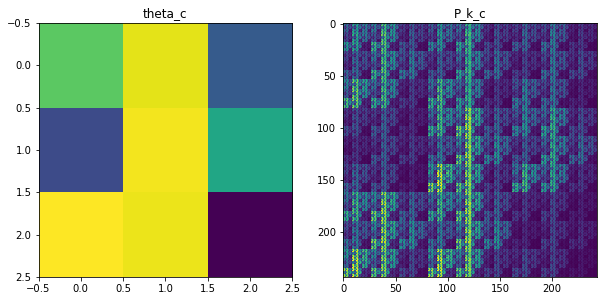

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(theta_c)
plt.title('theta_c')

plt.subplot(1,2,2)
plt.imshow(Pk_c_s)
plt.title('P_k_c')

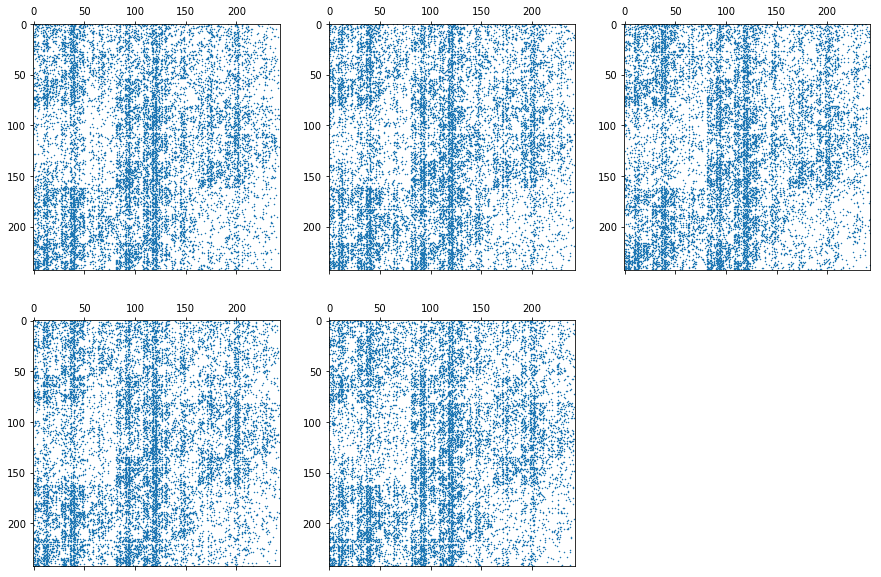

In [12]:
plt.figure(figsize=[15,10])
plt.title('All samples')
r = np.floor(np.sqrt(NumSamples))
c = np.ceil(float(NumSamples)/r)
for i in range(0,NumSamples):
    plt.subplot(r,c,i+1)
    plt.spy(G[i,:], markersize=0.5)